In [1]:
import torch
import torch.nn as nn
import logging
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/rosewt/Documentos/codigos2024/SordoMudos/src/')

import models.CNN.model as model

sys.path.insert(0, '/home/rosewt/Documentos/codigos2024/SordoMudos/')

from src.preprocessing.data_processing import process_imgs, load_data
from src.preprocessing.data_preprocessing import process_and_save_silhouette



In [2]:

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename="../logs/data_validation.log",  # Nombre del archivo de log
    filemode="a",  # Modo de apertura en append para no sobrescribir
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [3]:
# Configuración del dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Usando dispositivo: {device}")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


In [4]:
# Después de cargar los datos
_, data_test, _, label_mapping = load_data(data_dir='../../data/processed/split/')



In [5]:
import torch
import torch.nn.functional as F


def process_X(X, image_size=(224, 224)):
    X = torch.tensor(X, dtype=torch.float32)
    if X.dim() == 3:
        X = X.unsqueeze(1)
    elif X.dim() == 4:
        X = X.permute(0, 3, 1, 2)
    else:
        raise ValueError(f"Dimensión de X no soportada: {X.shape}")
    return X

def convert_to_tensors(X, y, image_size=(224, 224)):
    X = process_X(X, image_size)
    y = torch.tensor(y, dtype=torch.long)
    
    # Normalizar las imágenes
    X = X / 255.0
    
    # Redimensionar las imágenes al tamaño esperado por el modelo
    X = F.interpolate(X, size=image_size, mode='bilinear', align_corners=False)
    
    # Imprimir formas para depuración
    print(f"Forma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    
    return X, y

In [6]:
imgs_test, labels_test = data_test  # Desempaqueta la tupla en dos variables

print(f"Forma de imgs_test: {imgs_test.shape}")
print(f"Forma de labels_test: {labels_test.shape}")

labels_test = labels_test.astype(int)

Forma de imgs_test: (720, 200, 200)
Forma de labels_test: (720,)


In [7]:
X_test, y_test = convert_to_tensors(imgs_test, labels_test)

Forma de X: torch.Size([720, 1, 224, 224])
Forma de y: torch.Size([720])


In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
num_workers = 4
pin_memory = True

# Crear el DataLoader para el conjunto de prueba
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [9]:
!pip install seaborn > /dev/null

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, criterion, device, label_mapping):
    model.eval()
    test_loss = 0
    test_correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    test_accuracy = test_correct / len(data_loader.dataset)
    avg_test_loss = test_loss / len(data_loader)
    
    logging.info(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Generar reporte de clasificación
    report = classification_report(all_labels, all_predictions, target_names=list(label_mapping.keys()))
    logging.info(f"Reporte de Clasificación:\n{report}")
    
    # Generar matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap='Blues')
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas Reales')
    plt.title('Matriz de Confusión')
    plt.show()

    return all_labels, all_predictions

/tmp/ipykernel_48198/1006947737.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device)) # Cargar los pesos de

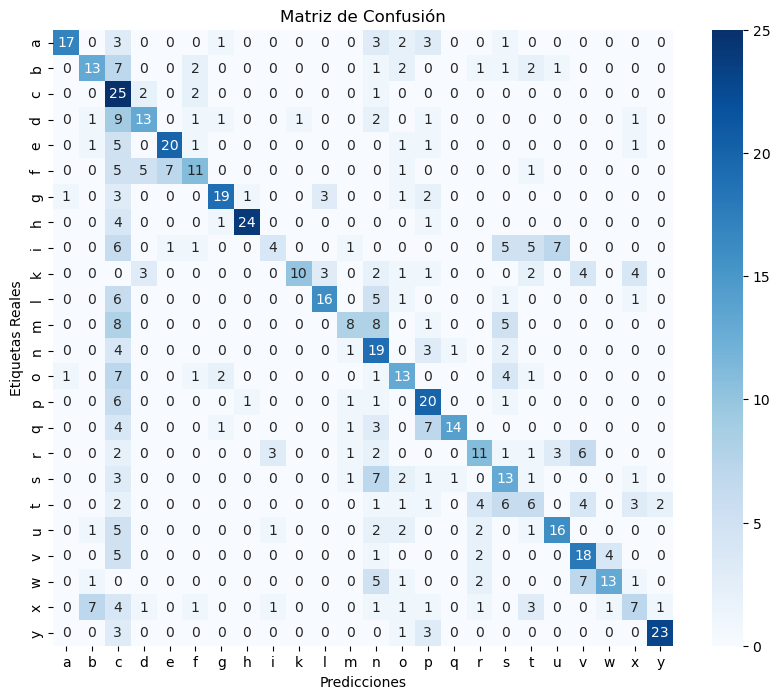

In [11]:
import models.CNN.model as model


#if torch.cuda.is_available():
#    model = model.to(device) 


# Seleccionar el modelo y número de clases
num_classes = len(label_mapping)
model = model.RusticModel(num_classes).to(device)
# Alternativa: model = ViTModel(num_classes).to(device)

# Cargar los pesos del modelo entrenado
model_path = "../models/CNN/rustic.pth"  # Ruta de tu modelo entrenado
model.load_state_dict(torch.load(model_path, map_location=device)) # Cargar los pesos del modelo (No olvidar map_location=device)
model.eval()
logging.info(f"Modelo cargado exitosamente desde {model_path}")
   

criterion = nn.CrossEntropyLoss()

all_labels, all_predictions = evaluate_model(model, test_loader, criterion, device, label_mapping)

### Precision, recall, F1

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_additional_metrics(labels, predictions):
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    
    logging.info(f"Precisión (Precision): {precision:.4f}")
    logging.info(f"Exhaustividad (Recall): {recall:.4f}")
    logging.info(f"Puntuación F1 (F1-Score): {f1:.4f}")

# Dentro de la función evaluate_model, después de obtener all_labels y all_predictions
calculate_additional_metrics(all_labels, all_predictions)

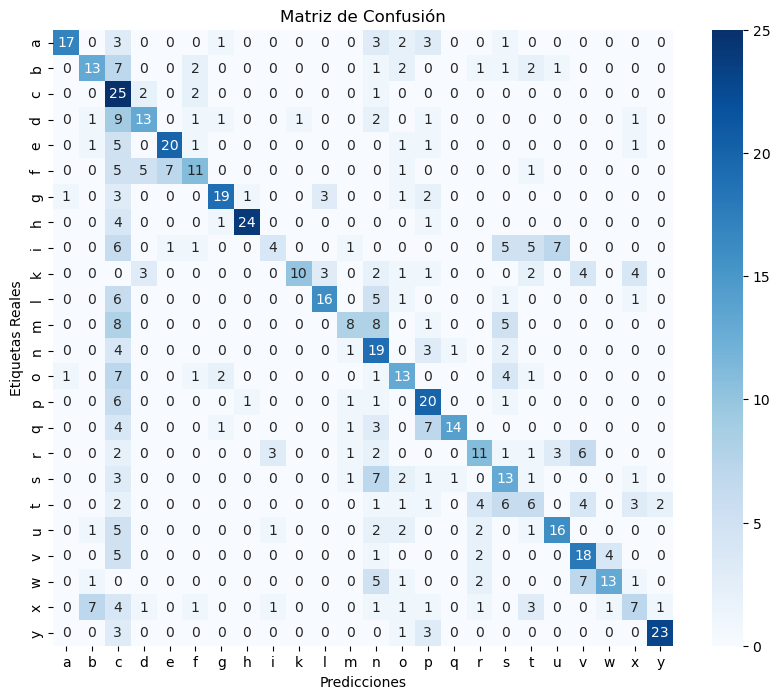

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, predictions, label_mapping):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap='Blues')
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas Reales')
    plt.title('Matriz de Confusión')
    plt.show()

# Llamar a la función dentro de evaluate_model
plot_confusion_matrix(all_labels, all_predictions, label_mapping)

## Pruebas unitarias

In [14]:
#import import_ipynb
#
from PIL import Image
from torchvision import transforms
import cv2
#


In [15]:
# from segment_anything import SamPredictor, sam_model_registry

# # Load the model checkpoint
# sam = sam_model_registry["vit_l"]

# # Initialize the predictor
# predictor = SamPredictor(sam)

# # Load your image
# image_path = "./data/raw/captures/a/a(1).png"
# image = cv2.imread(image_path)

# # Set the image for the predictor
# predictor.set_image(image)

# # Define your input prompts
# input_prompts = {
#     "boxes": [[50, 50, 200, 200]],  # Example bounding box
#     "points": [[100, 100]],         # Example point
#     # Add other prompts as needed
# }

# # Make predictions
# masks, _, _ = predictor.predict(input_prompts)

# # Display the masks
# for mask in masks:
#     cv2.imshow("Mask", mask)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [16]:
'''
def preprocess_single_image(model, val, predict):

    model.eval()
    with torch.no_grad():    
        image = val.unsqueeze(0).to(device)  # Añadir dimensión batch
        labels = predict.unsqueeze(0).to(device)
        # Forward pass
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        
        # Guardar predicciones y etiquetas
        v = labels.item()
        p = predicted.item()

    return v, p
'''


'\ndef preprocess_single_image(model, val, predict):\n\n    model.eval()\n    with torch.no_grad():    \n        image = val.unsqueeze(0).to(device)  # Añadir dimensión batch\n        labels = predict.unsqueeze(0).to(device)\n        # Forward pass\n        output = model(image)\n        _, predicted = torch.max(output.data, 1)\n        \n        # Guardar predicciones y etiquetas\n        v = labels.item()\n        p = predicted.item()\n\n    return v, p\n'

In [17]:
sys.path.insert(0, '/home/rosewt/Documentos/codigos2024/SordoMudos/src/')

from preprocessing.data_preprocessing import binarize_with_canny

def preprocess_single_image(image_path, verbose=False):
    """
    Carga y preprocesa una sola imagen para pasarla por el modelo.
    """
    # Definir las transformaciones necesarias
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
        transforms.Resize((224, 224)),               # Redimensionar a 224x224
        transforms.ToTensor(),                       # Convertir a tensor
        transforms.Normalize((0.5,), (0.5,))         # Normalizar (ajusta según el entrenamiento)
    ])

    # Cargar la imagen
    image = cv2.imread(image_path)

    image = binarize_with_canny(image)

    image = Image.fromarray(image)

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    
    # Aplicar transformaciones
    image = transform(image)
    if verbose:
        plt.subplot(1, 2, 2)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.show()
    
    # Agregar una dimensión para el batch
    image = image.unsqueeze(0)
    
    return image


ImportError: cannot import name 'binarize_with_canny' from 'preprocessing.data_preprocessing' (/home/rosewt/Documentos/codigos2024/SordoMudos/src/preprocessing/data_preprocessing.py)

In [ ]:
def predict_single_image(model, image_tensor, label_mapping):
    """
    Realiza una predicción para una sola imagen.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        # Pasar la imagen por el modelo
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        
        # Obtener la predicción
        _, predicted = torch.max(output, 1)

        predicted_label = predicted.item()
        
        # Mapear el índice a la etiqueta correspondiente
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]
        
    return label_name


In [ ]:
from pathlib import Path

In [ ]:
def preprocess(path):
    imgs = [file for file in Path(path).iterdir() if file.is_file() and file.suffix in ['.png', '.jpg', '.jpeg']]
    results = [preprocess_single_image(img) for img in imgs]
    return results

In [ ]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["<model_type>"](checkpoint="<path/to/checkpoint>")
predictor = SamPredictor(sam)
predictor.set_image(<your_image>)
masks, _, _ = predictor.predict(<input_prompts>)

In [ ]:
# Ruta de la imagen de prueba

test_image_path = '/home/rosewt/Documentos/codigos2024/SordoMudos/data/raw/captures/a/a(1).png'


test_path = "/home/rosewt/Documentos/codigos2024/SordoMudos/data/raw/captures/a"


img = preprocess_single_image(test_image_path, verbose=True)

img.squeeze().shape


#
#print(type(imgs[0]))
#print(len(imgs[0]))
#
#resize_img =  imgs[0].squeeze().numpy()
#
#plt.imshow(resize_img, cmap="binary")
#plt.show()
#
#label_to_index = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}
#
#
#y_val = [0] * len(imgs)
#
#
#imgs_resized = imgs

#print(len(imgs_resized))

#X_val = torch.tensor(imgs_resized, dtype=torch.float32).unsqueeze(1)  # Añade dimensión de canal
#y_val = torch.tensor(y_val, dtype=torch.long)

NameError: name 'binarize_with_canny' is not defined

In [ ]:
# KAMI SAMA TASUKETE KUDASAI 

# Convertir los datos de validación a tensores
#X_val, y_val = [convert_to_tensors(img, y) for img, y in  zip(imgs, y_val)]

In [ ]:
y_val

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Evaluar el modelo
val_loss = 0
val_correct = 0
with torch.no_grad():
    for i in range(len(X_val)):
        images = X_val[i].unsqueeze(0).to(device)  # Agregar dimensión batch
        labels = y_val[i].unsqueeze(0).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Acumulación de la pérdida y precisión
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()

# Calcular la pérdida y precisión de validación
val_loss /= len(X_val)
val_accuracy = val_correct / len(X_val)
logging.info(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
